# 3 main models based:
- Kmeans
- Kmedoids
- Agglomerative Clustering (Hierarchical Clustering)

In [1]:
#imports
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('../../data/modelers_data.csv')
data_s=pd.read_csv('../../data/modelers_data_encoded_scaled.csv')
data_s

,Price,Rating,processor_tier,num_cores,num_threads,ram_memory,primary_storage_is_SSD,primary_storage_capacity,secondary_storage_capacity,gpu_is_dedicated,...,model_thinkpad,model_tuf,model_v14,model_v15,model_victus,model_vivobook,model_vostro,model_yoga,model_zbook,model_zenbook
0,0.343118,0.379310,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.625381,0.724138,0.777778,0.545455,0.625,0.375,1.0,0.492063,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355625,0.482759,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997201,1.000000,1.000000,1.000000,1.000,0.000,1.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.326659,0.241379,0.333333,0.272727,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0.301869,0.500000,0.555556,0.181818,0.375,0.375,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0.429821,0.689655,0.555556,0.181818,0.375,0.125,1.0,0.238095,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
690,0.367599,0.551724,0.555556,0.090909,0.250,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
691,0.493192,0.568966,0.555556,0.363636,0.375,0.125,1.0,0.238095,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# JOHN'S functions

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.883514
[t-SNE] KL divergence after 3850 iterations: 0.163174


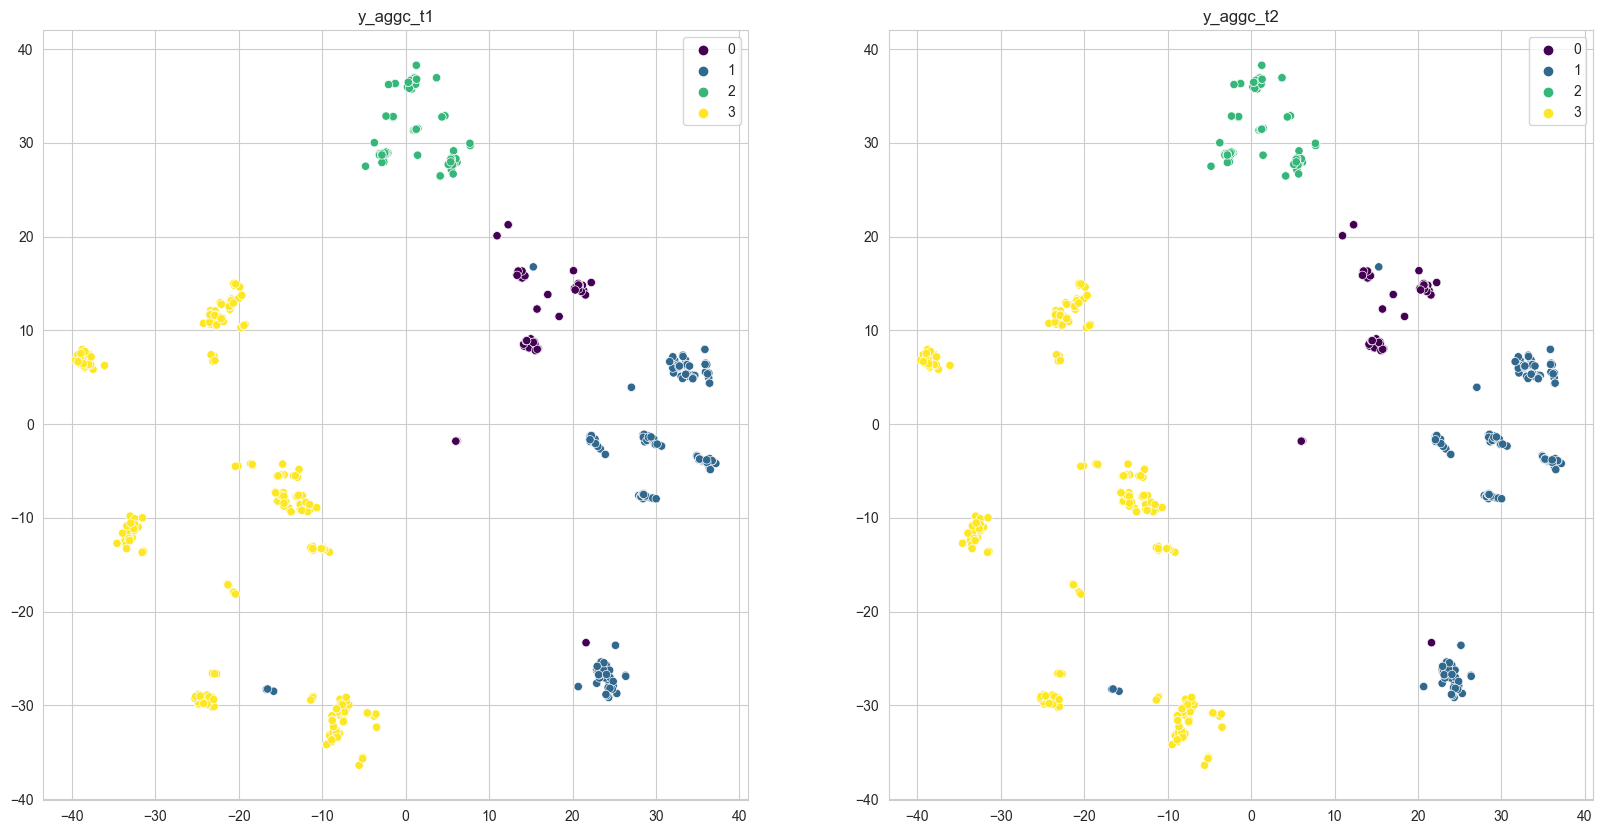

In [3]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
        self.scaler = [MinMaxScaler() for _ in range(len(classes))]
        self.classes = classes

    def fit(self, X, y=None):
        for i,col in enumerate(self.classes):
            self.scaler[i].fit(X[[col]])
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
            Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

class transformer_1(BaseEstimator, TransformerMixin):

    def fit(self,df,y= None):
        return self

    def transform(self,X,y= None):

        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height)
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])


        return X_copy

class transformer_2(BaseEstimator, TransformerMixin):

    def fit(self,df,y= None):
        return self

    def transform(self,X,y= None):

        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height)
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])


        return X_copy

class transformer_3(BaseEstimator, TransformerMixin):

    def fit(self,df,y= None):
        return self

    def transform(self,X,y= None):

        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        new_column=X_copy['processor_tier'].str.extract(r'(\d)')
        new_column=new_column.fillna(0)
        X_copy['processor_tier']=new_column

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height)
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])


        return X_copy


classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']
ppl = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model_matrix = model_data.values
model_aggc_7 = AgglomerativeClustering(n_clusters=7)
y_aggc_7 = model_aggc_7.fit_predict(model_matrix)
def tsne_plot(df,ys,r,c,predictions_title):
    df_copy = df.copy()
    tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
    digits_proj = tSNE.fit_transform(df_copy)

    figure,ax = plt.subplots(r,c,figsize=(20,10))
    ax = ax.flatten()
    predictions = ys
    predictions_title = predictions_title
    for i in range(len(predictions)):
        sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
        ax[i].set_title(predictions_title[i])
    plt.show()

ppl1 = Pipeline([
    ('transformer',transformer_1()),
    ('minmax',MinMaxTransformer(classess))
])
ppl2 = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
])

datatest = data.copy()
model_matrix1 = ppl1.fit_transform(datatest).values
model_matrix2 = ppl2.fit_transform(datatest).values

model_aggc_t1 = AgglomerativeClustering(n_clusters=4)
model_aggc_t2 = AgglomerativeClustering(n_clusters=4)

y_aggc_t1 = model_aggc_t1.fit_predict(model_matrix1)
y_aggc_t2 = model_aggc_t2.fit_predict(model_matrix2)

tsne_plot(model_data,[y_aggc_t1,y_aggc_t2],1,2,['y_aggc_t1','y_aggc_t2'])

In [4]:
def show_metrics(X,model):
    # input:
    # X = przetransformowany dataFrame
    # model = niewytrenowany model
    X = X.values
    y = model.fit_predict(X)
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)

    return([silhouette,db_index,ch_index])

def wyniki(model1,model2,model3,n=1):
    # input: 3 niewytrenowane modele
    model_data_ds = data_s.copy()

    classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
                'ram_memory','primary_storage_capacity','secondary_storage_capacity']
    ppl1 = Pipeline([
        ('transformer',transformer_3()),
        ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data_t1 = ppl1.fit_transform(datatest)

    ppl2 = Pipeline([
        ('transformer',transformer_2()),
        ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data_t2 = ppl2.fit_transform(datatest)

    w1,w2,w3 = [],[],[]

    for i in range(n):
        w1.append(show_metrics(model_data_ds,model1))
        w2.append(show_metrics(model_data_t1,model2))
        w3.append(show_metrics(model_data_t2,model3))

    df = pd.DataFrame({
        "metric" : ["silhouette","davies_bouldin","calinski_harabasz"],
        "data_s" : pd.DataFrame(w1).mean(),
        "transformer_3" : pd.DataFrame(w2).mean(),
        "transformer_2" : pd.DataFrame(w3).mean()
    })

    df.set_index('metric',inplace=True)

    return df


# MODEL AGGLOMERATIVE CLUSTERING

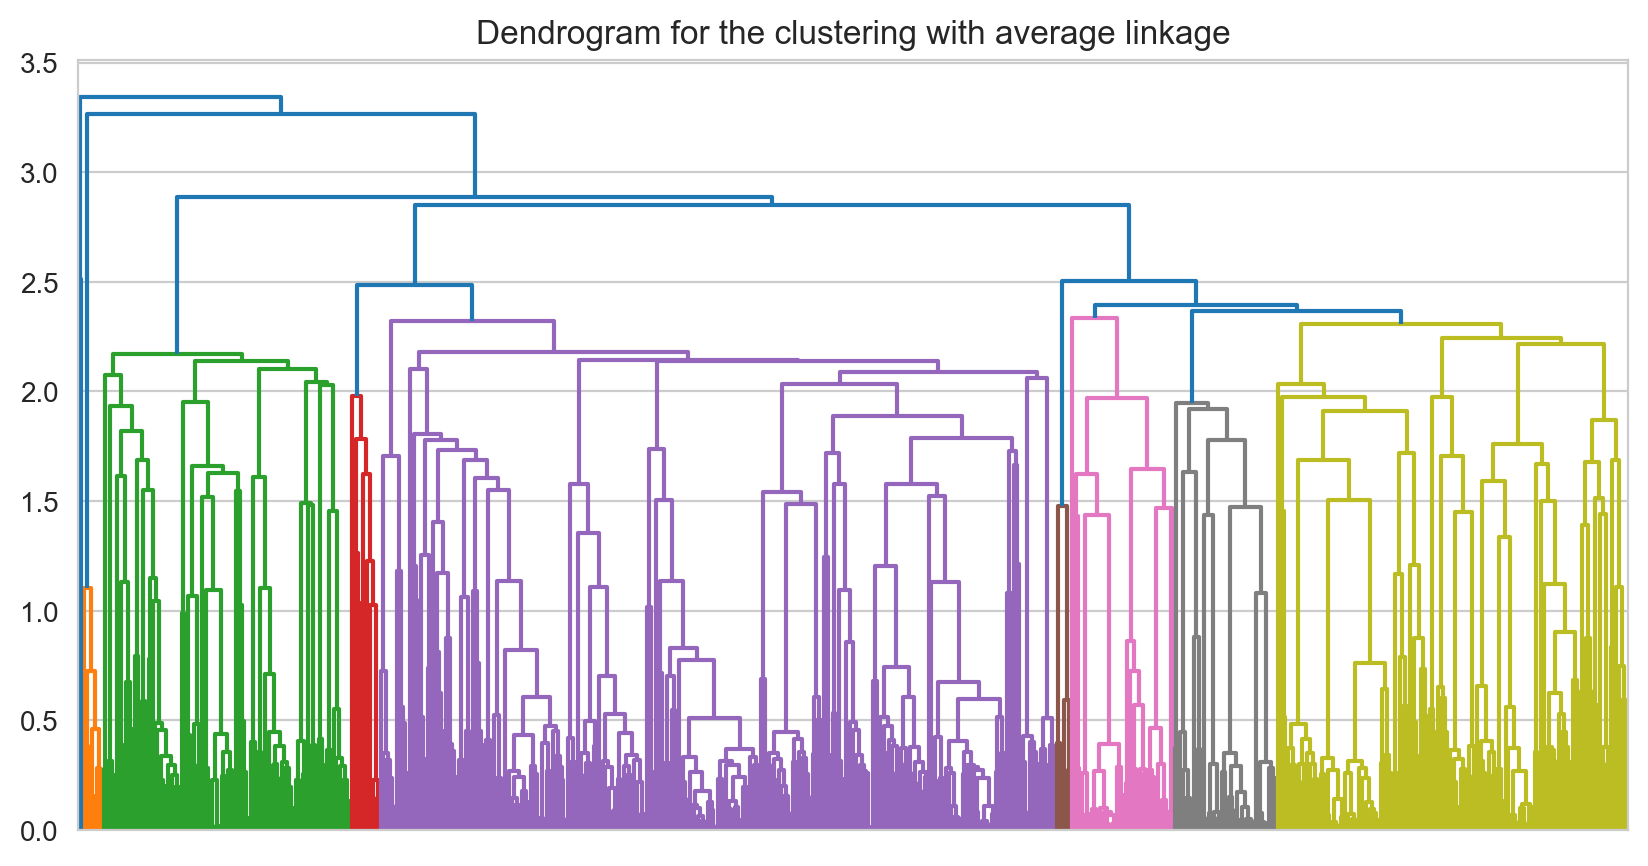

In [5]:
from scipy.cluster import hierarchy

Z=hierarchy.linkage(data_s, 'average')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.title('Dendrogram for the clustering with average linkage')
plt.xticks([])
plt.show()

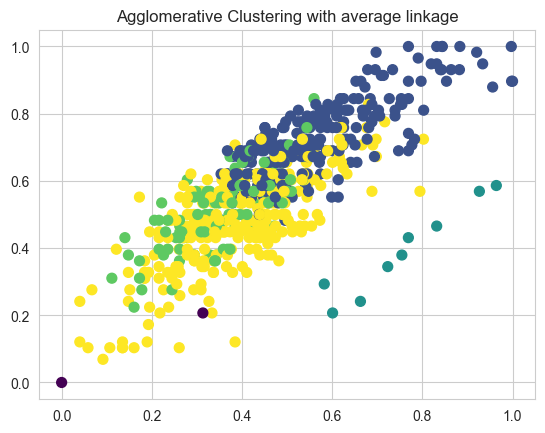

In [6]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=2.6)
y=model.fit_predict(data_s)
plt.scatter(data_s.iloc[:, 0], data_s.iloc[:, 1], c=y, s=50, cmap='viridis')
plt.title('Agglomerative Clustering with average linkage')
plt.show()

In [7]:
data['cluster']=y
data

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
0,949,msi,MSI Modern 15 B7M-072IN Laptop (Ryzen 5 7530U/...,43990,53,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,3
1,584,msi,MSI Prestige 16 A13UCX-250IN Laptop (13th Gen ...,119990,73,intel,core i7,14,20,16,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,1
2,937,acer,Acer Aspire 7 A715-75G Gaming Laptop (10th Gen...,45990,59,intel,core i5,4,8,8,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,1
3,416,msi,MSI CreatorPro Z16 HX B13VKTO-214IN Laptop (13...,449990,89,intel,core i9,24,32,4,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,1
4,538,acer,Acer Aspire 3 Spin 14 NX.KENSI.002 Laptop (Int...,41490,45,intel,core i3,8,8,8,...,0,intel,integrated,False,14.0,1920,1200,windows,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,114,acer,Acer Aspire Lite AL15 Laptop (AMD Ryzen 5 5500...,37990,60,amd,ryzen 5,6,12,16,...,0,amd,integrated,False,15.6,1920,1080,windows,1,3
689,281,hp,HP Victus 15-fb0050AX Gaming Laptop (AMD Ryzen...,59871,71,amd,ryzen 5,6,12,8,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,1
690,872,dell,Dell Vostro 15 3510 2023 Laptop (11th Gen Core...,47990,63,intel,core i5,4,8,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,4
691,447,hp,HP 240 G9 821J4PA Laptop (12th Gen Core i5/ 8G...,74999,64,intel,core i5,10,12,8,...,0,intel,integrated,False,14.0,1366,768,windows,1,4


In [8]:
#how many procesor brand in each cluster
data.groupby('cluster')['gpu_brand'].value_counts()

cluster  gpu_brand
0        arm            2
1        nvidia       247
         amd            9
2        apple          9
3        amd          111
4        intel        315
Name: count, dtype: int64

In [9]:
# how many gpu type in each cluster
data.groupby('cluster')['gpu_type'].value_counts()

cluster  gpu_type  
0        integrated      2
1        dedicated     256
2        apple           9
3        integrated    110
         dedicated       1
4        integrated    314
         dedicated       1
Name: count, dtype: int64

In [10]:
#how many procesor brand in each cluster
data.groupby('cluster')['year_of_warranty'].value_counts()

cluster  year_of_warranty
0        1                     2
1        1                   205
         2                    41
         No information        7
         3                     3
2        1                     9
3        1                   109
         2                     1
         3                     1
4        1                   299
         2                     8
         3                     4
         No information        4
Name: count, dtype: int64

In [11]:
#how count procesor brand in each cluster
data.groupby('cluster')['processor_brand'].value_counts()

cluster  processor_brand
0        other                2
1        intel              175
         amd                 81
2        apple                9
3        amd                110
         intel                1
4        intel              314
         amd                  1
Name: count, dtype: int64

In [12]:
m=AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=2.6)

wyniki(m,m,m,50)

,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.253082,0.389947,0.390063
davies_bouldin,1.299237,0.831509,0.830183
calinski_harabasz,94.456171,265.105151,265.237611


# MODEL KMEANS

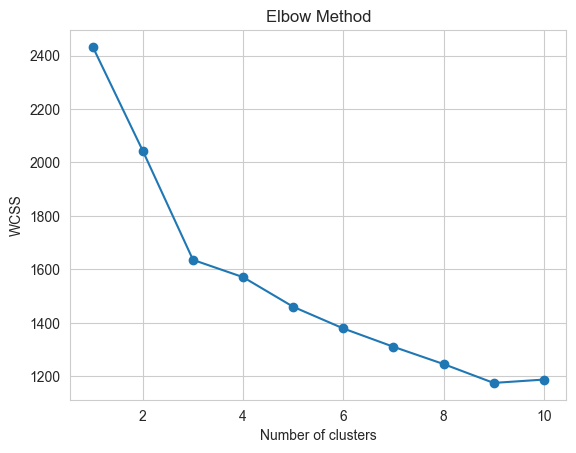

In [13]:
#how many clusters
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

scores = count_wcss_scores(data_s, 10)
plt.plot(range(1, 11), scores, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

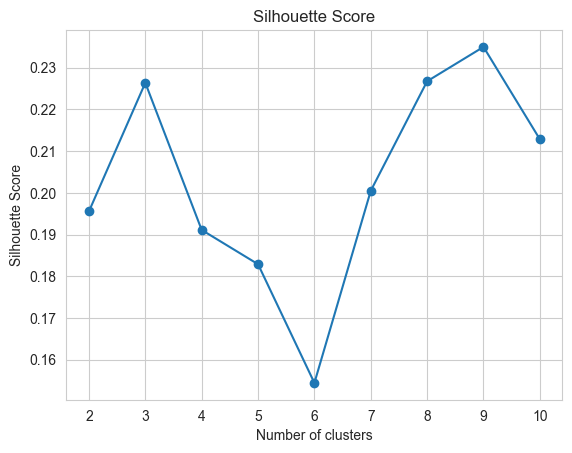

In [14]:
# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num

    scores = []
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)

    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    
cluster_num = range(2, 11)
wcss_scores = count_clustering_scores(data_s, cluster_num, KMeans, silhouette_score)
plt.plot(cluster_num, wcss_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')  
plt.show()

In [15]:
# MODEL KMEANS
model = KMeans(n_clusters=7, random_state=0)

wyniki(model,model,model,50)

,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.207161,0.257770,0.229279
davies_bouldin,1.907651,1.801294,1.970499
calinski_harabasz,97.900351,315.560644,292.675250


In [16]:
# Model Kmedoids
from sklearn_extra.cluster import KMedoids

model = KMedoids(n_clusters=7, random_state=0)

wyniki(model,model,model)


,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.151902,0.265327,0.265646
davies_bouldin,1.933523,1.729544,1.725845
calinski_harabasz,58.453100,295.346400,294.931537


In [17]:
model=KMedoids(n_clusters=4, random_state=0)

wyniki(model,model,model,50)

,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.095491,0.288017,0.287462
davies_bouldin,3.413532,1.949363,1.949898
calinski_harabasz,60.190302,452.894049,451.818381
